# **Problema de clasificacion binaria: Regresion Logistica**

En este ejercicio vamos a analizar una muestra de datos para clasificacion binaria. Inicialmente partimos del supuesto que nuestros datos se comportan como el siguiente modelo:

$$
\begin{align*}
    Y = f(X) + \varepsilon
\end{align*}
$$

De donde $X \in \mathbb{R}^d$ son las caracteristicas (features) que nos interesa contrarrestar con la salida $Y \in \mathbb{R}$. Ademas tenemos que $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ es el ruido inherente de la muestra aleatoria escogida.

Para un problema de clasificacion binaria, es natural pensar que la variable aleatoria de salida $Y$ tenga solamente dos resultados, por lo cual podemos considerar que tiene una distribucion Bernoulli, es decir, tenemos que $Y \sim \text{Bernoullli}(p)$ por lo cual tiene la siguiente funcion densidad de masa:

$$
\begin{align*}
    g(y) = p^y(1-p)^{n-y}
\end{align*}
$$

Sin embargo, recordemos que nos interesa es poder conocer el comportamiento de la variable aleatoria condicional $Y | X=x$. Para cada valor $x \in \mathcal{X}$ tendremos una correspondiente salida, y a esta salida le correspondera una probabilidad. Dicho esto, es logico pensar que $Y | X=x$ tambien tendra una distribucion Bernoulli, en donde $p$ dependera del $x$ escogido, es decir, tenemos que $Y | X=x \sim \text{Bernoulli}(p_x)$ y la idea es (punto a punto) poder hallar un estimador de esta probabilidad.

----

## **Datos del modelo**

Vamos a empezar importando un dataset de clasificacion binaria. En este caso vamos a hacer algo sencillo y usar las siguientes variables:

$$
\begin{align*}
    X: \text{Radio promedio del tumor (m)} \\
    y: \text{El tumor es maligno o benigno}
\end{align*}
$$

Aca nos podemos dar cuenta que realmente no tenemos un vector de caracteristicas, sino simplemente un escalar. Sin embargo es bueno acostumbrarse a ver esto como un vector ya que computacionalmente es como las librerias de inteligencia artificial suelen hacer los calculos

In [244]:
import pandas as pd

df = pd.read_csv("../data/breast-cancer.csv")

df.sample(n=5)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
149    869931         B       13.740         17.91           88.12      585.0   
437    909220         B       14.040         15.98           89.78      611.2   
68     859471         B        9.029         17.33           58.79      250.5   
47      85715         M       13.170         18.66           85.98      534.6   
3    84348301         M       11.420         20.38           77.58      386.1   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
149          0.07944           0.06376         0.02881              0.01329   
437          0.08458           0.05895         0.03534              0.02944   
68           0.10660           0.14130         0.31300              0.04375   
47           0.11580           0.12310         0.12260              0.07340   
3            0.14250           0.28390         0.24140              0.10520   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
149  ...          22.46            97.19       725.9           0.09711   
437  ...          21.58           101.20       750.0           0.11950   
68   ...          22.65            65.50       324.7           0.14820   
47   ...          27.95           102.80       759.4           0.17860   
3    ...          26.50            98.87       567.7           0.20980   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
149             0.1824           0.1564               0.06019          0.2350   
437             0.1252           0.1117               0.07453          0.2725   
68              0.4365           1.2520               0.17500          0.4228   
47              0.4166           0.5006               0.20880          0.3900   
3               0.8663           0.6869               0.25750          0.6638   

     fractal_dimension_worst  Unnamed: 32  
149                  0.07014          NaN  
437                  0.07234          NaN  
68                   0.11750          NaN  
47                   0.11790          NaN  
3                    0.17300          NaN  

[5 rows x 33 columns]

----

## **Transformaciones del dataset**

Ya que ahora conocemos los datos, podemos identificar las columnas que queremos usar, que en este caso seran `radius_mean` y `diagnosis`. Sin embargo podemos observar que la columna del diagnostico, si bien es binaria, sus datos no son numericos, por lo cual podemos hacer una transformacion para convertirlos

In [245]:
df = df.drop(columns='Unnamed: 32')
df['diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x == "M" else 0)

In [246]:
df.sample(n=5)

id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
556   924964          0        10.16         19.59           64.73      311.7   
122   865423          1        24.25         20.20          166.20     1761.0   
172    87164          1        15.46         11.89          102.50      736.9   
52    857374          0        11.94         18.24           75.71      437.6   
208  8810158          0        13.11         22.54           87.02      529.4   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
556          0.10030           0.07504        0.005025              0.01116   
122          0.14470           0.28670        0.426800              0.20120   
172          0.12570           0.15550        0.203200              0.10970   
52           0.08261           0.04751        0.019720              0.01349   
208          0.10020           0.14830        0.087050              0.05102   

     ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
556  ...         10.65          22.88            67.88       347.3   
122  ...         26.02          23.99           180.90      2073.0   
172  ...         18.79          17.04           125.00      1102.0   
52   ...         13.10          21.33            83.67       527.2   
208  ...         14.55          29.16            99.48       639.3   

     smoothness_worst  compactness_worst  concavity_worst  \
556            0.1265            0.12000          0.01005   
122            0.1696            0.42440          0.58030   
172            0.1531            0.35830          0.58300   
52             0.1144            0.08906          0.09203   
208            0.1349            0.44020          0.31620   

     concave points_worst  symmetry_worst  fractal_dimension_worst  
556               0.02232          0.2262                  0.06742  
122               0.22480          0.3222                  0.08009  
172               0.18270          0.3216                  0.10100  
52                0.06296          0.2785                  0.07408  
208               0.11260          0.4128                  0.10760  

[5 rows x 32 columns]

In [247]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = df[['radius_mean']]
y = df['diagnosis']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(X[:50].T)
print("\n")
print(y[:50].values)

[[0.52103744 0.64314449 0.60149557 0.2100904  0.62989256 0.25883856
  0.5333428  0.31847224 0.28486914 0.25931185 0.42780065 0.41644186
  0.57688485 0.41975484 0.31941881 0.35775474 0.36438071 0.43300677
  0.60717497 0.31042643 0.2886554  0.11940934 0.3956174  0.6710682
  0.45761749 0.48080837 0.35964788 0.55038099 0.39372427 0.50115954
  0.55132756 0.22996829 0.47512897 0.58161768 0.43300677 0.46187704
  0.34402953 0.28628899 0.37905249 0.30758673 0.3056936  0.18784609
  0.57215202 0.29812107 0.29291495 0.55227413 0.0575039  0.29291495
  0.23990724 0.30806001]]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 0 0]


---

## **Graficas de los datos**

Ya que ahora tenemos almacenadas en variables por separado a $X$ y a $y$ podemos graficar los datos para ver como se comportan

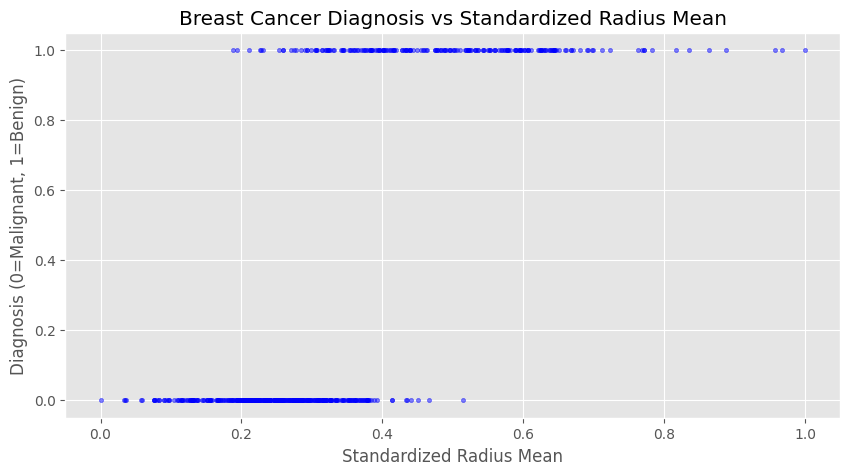

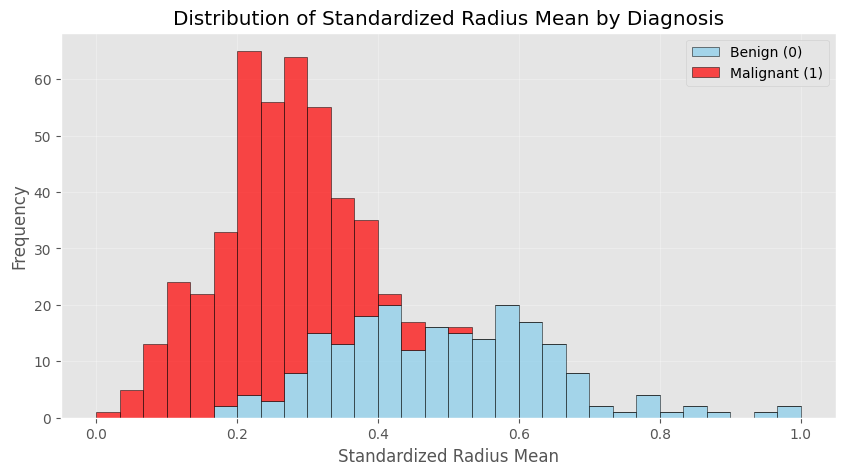

In [248]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")

plt.figure(figsize=(10, 5))
plt.scatter(X, y, marker='.', alpha=0.5, c='b')
plt.xlabel('Standardized Radius Mean')
plt.ylabel('Diagnosis (0=Malignant, 1=Benign)')
plt.title('Breast Cancer Diagnosis vs Standardized Radius Mean')
plt.show()

plt.figure(figsize=(10, 5))
# Separate data by target variable
malignant_data = np.array(X[y == 0]).flatten()
benign_data = np.array(X[y == 1]).flatten()

# Create stacked histogram with different colors
plt.hist([benign_data, malignant_data], bins=30, alpha=0.7, 
         color=['skyblue', 'red'], edgecolor='black', 
         label=['Benign (0)', 'Malignant (1)'], stacked=True)
plt.xlabel('Standardized Radius Mean')
plt.ylabel('Frequency')
plt.title('Distribution of Standardized Radius Mean by Diagnosis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---


## **Regresion Logistica**

Recordemos que establecimos que $Y | X=x \sim \text{Bernoulli}(p_x)$, donde queremos estimar $p_x$ para cada valor de $x$. Para ello podriamos proponer cualquier funcion de la forma $p: \mathbb{R} \to [0,1]$ y ademas nos gustaria que fuese diferenciable para temas de optimizacion.

Para ello, definimos la cantidad de *odds* como lo siguiente:

$$
\text{odds}(p) = \frac{p}{1-p}
$$

Esta cantidad es importante pues lo que nos dice basicamente es cuantas veces mas probable es que ocurra el evento versus que no ocurra. Ademas, la particularidad del odds es que es una cantidad que puede tomar cualquier valor positivo.

Sabemos ademas que la probabilidad tiene una naturaleza exponencial, por lo cual es razonable tambien considerar el *log-odds* y de esta forma expresarlo en terminos de una combinacion lineal para de esa manera obtener una expresion cerrada para $p(x)$

$$
\ln\left(\frac{p}{1-p}\right) = \theta_0 + \theta_1x \longrightarrow p(x) = \frac{1}{1 + e^{-(\theta_0 + \theta_1x)}}
$$

----

## **Entrenamiento del modelo**

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
np.set_printoptions(suppress=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)

/tmp/ipykernel_1621/3035621469.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=11)
/tmp/ipykernel_1621/3035621469.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=11)


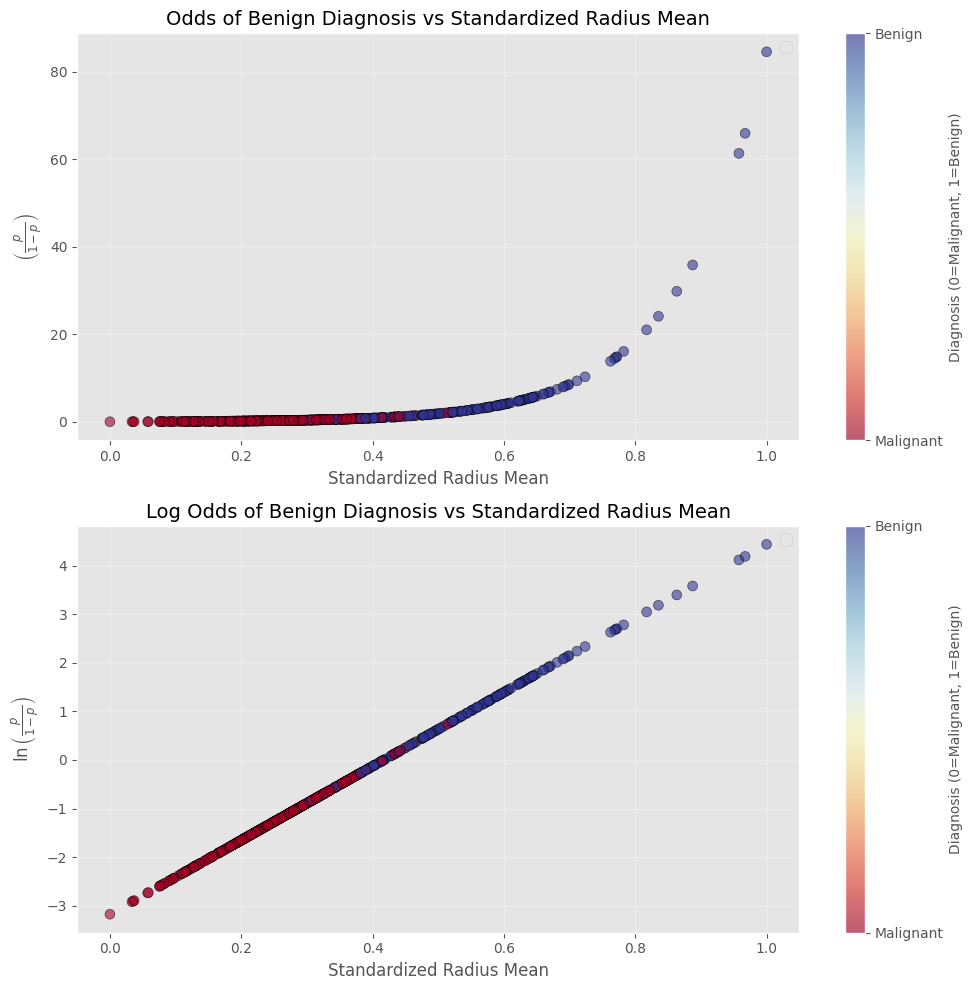

In [250]:
plt.figure(figsize=(10, 10))

# First subplot - Odds
plt.subplot(2, 1, 1)

y_prob_all = model.predict_proba(X)[:, 1]

# Calculate odds for each point
odds_all = y_prob_all / (1 - y_prob_all)

# Create scatter plot
plt.scatter(np.array(X).flatten(), odds_all, alpha=0.6, c=y, cmap='RdYlBu', s=50, 
           edgecolors='black', linewidth=0.5)

# Create smooth curve for odds
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_prob_range = model.predict_proba(X_range)[:, 1]
odds_range = y_prob_range / (1 - y_prob_range)

plt.xlabel('Standardized Radius Mean', fontsize=12)
plt.ylabel(r'$\left(\frac{p}{1-p}\right)$', fontsize=12)
plt.title('Odds of Benign Diagnosis vs Standardized Radius Mean', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add colorbar for first subplot
cbar1 = plt.colorbar()
cbar1.set_label('Diagnosis (0=Malignant, 1=Benign)', fontsize=10)
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels(['Malignant', 'Benign'])

# Second subplot - Log Odds
plt.subplot(2, 1, 2)

# Calculate log odds (log of odds)
log_odds_all = np.log(odds_all)

# Create scatter plot for log odds
plt.scatter(np.array(X).flatten(), log_odds_all, alpha=0.6, c=y, cmap='RdYlBu', s=50, 
           edgecolors='black', linewidth=0.5)

# Create smooth curve for log odds
log_odds_range = np.log(odds_range)
plt.xlabel('Standardized Radius Mean', fontsize=12)
plt.ylabel(r'$\ln\left(\frac{p}{1-p}\right)$', fontsize=12)
plt.title('Log Odds of Benign Diagnosis vs Standardized Radius Mean', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add colorbar for second subplot
cbar2 = plt.colorbar()
cbar2.set_label('Diagnosis (0=Malignant, 1=Benign)', fontsize=10)
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['Malignant', 'Benign'])

plt.tight_layout()
plt.show()

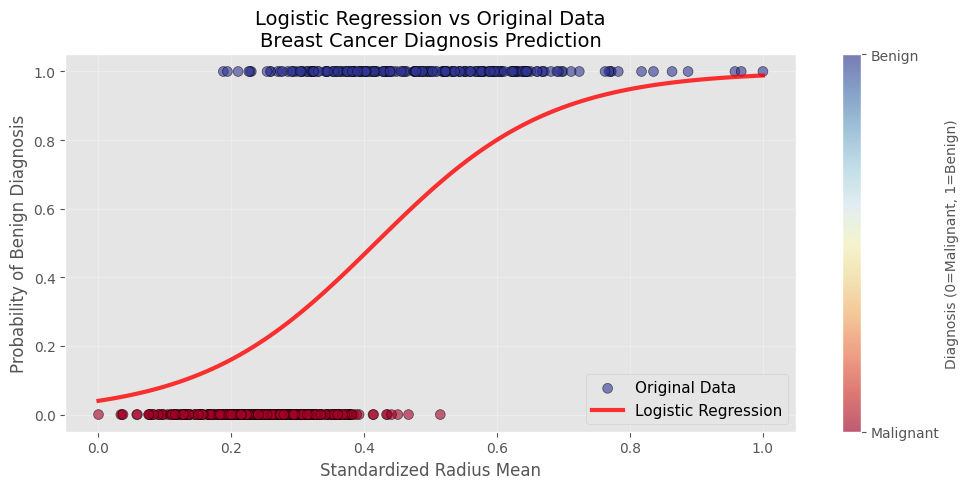

In [251]:
plt.figure(figsize=(10, 5))

# Create a range of X values for smooth logistic curve
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_prob_range = model.predict_proba(X_range)[:, 1]  # Probability of class 1 (benign)

# Plot original scatter data
plt.scatter(X, y, alpha=0.6, c=y, cmap='RdYlBu', s=50, 
           label='Original Data', edgecolors='black', linewidth=0.5)

# Plot logistic regression curve
plt.plot(X_range, y_prob_range, 'red', linewidth=3, 
         label='Logistic Regression', alpha=0.8)

# Customize the plot
plt.xlabel('Standardized Radius Mean', fontsize=12)
plt.ylabel('Probability of Benign Diagnosis', fontsize=12)
plt.title('Logistic Regression vs Original Data\nBreast Cancer Diagnosis Prediction', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add colorbar for scatter points
cbar = plt.colorbar()
cbar.set_label('Diagnosis (0=Malignant, 1=Benign)', fontsize=10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Malignant', 'Benign'])

plt.tight_layout()
plt.show()

In [252]:
print("Logistic Regression Parameters:")
print(f"Intercept (β₀): {model.intercept_[0]:.6f}")
print(f"Coefficient (β₁): {model.coef_[0][0]:.6f}")


print(f"\nLogistic Regression Equation:")
print(f"log(odds) = {model.intercept_[0]:.6f} + {model.coef_[0][0]:.6f} * X")
print(f"probability = 1 / (1 + exp(-({model.intercept_[0]:.6f} + {model.coef_[0][0]:.6f} * X)))")


Logistic Regression Parameters:
Intercept (β₀): -3.176037
Coefficient (β₁): 7.613992

Logistic Regression Equation:
log(odds) = -3.176037 + 7.613992 * X
probability = 1 / (1 + exp(-(-3.176037 + 7.613992 * X)))


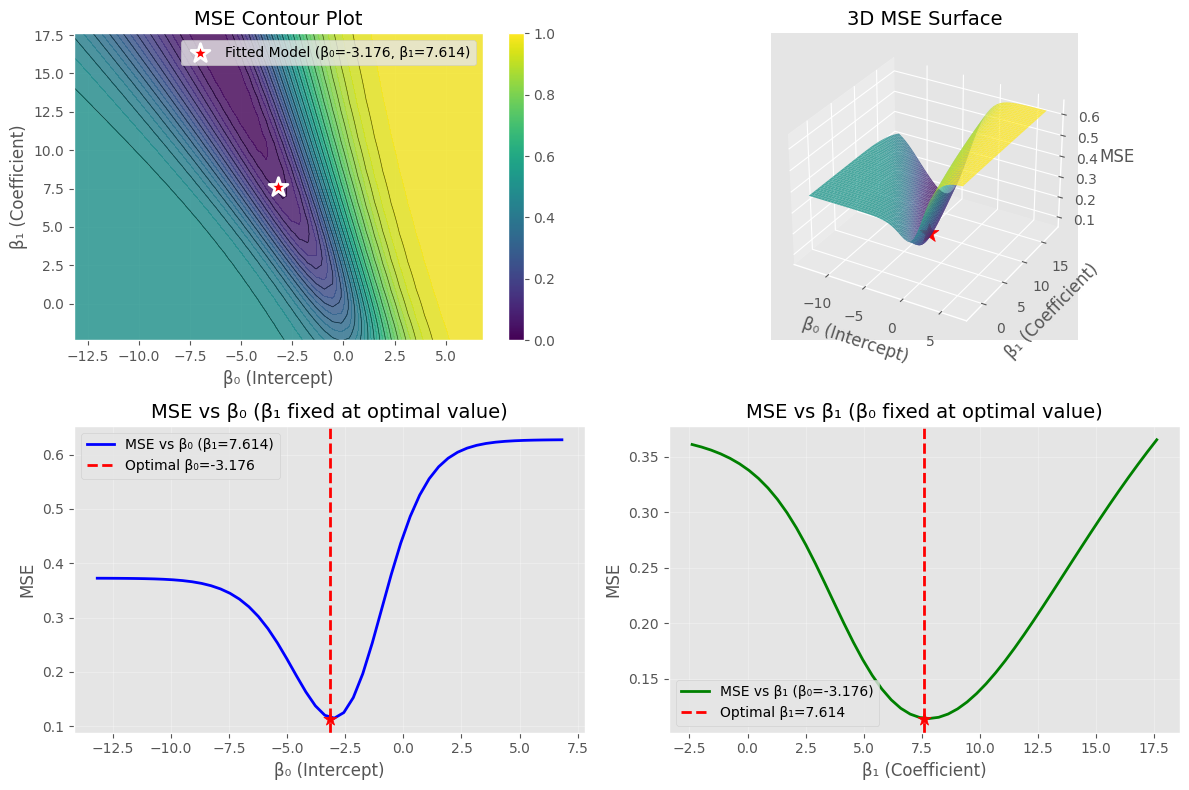

Analysis of MSE with respect to individual parameters:
Optimal β₀: -3.176037
Optimal β₁: 7.613992
MSE at optimal parameters: 0.113908

Minimum MSE in β₀ slice (β₁=7.614): 0.115053
Minimum MSE in β₁ slice (β₀=-3.176): 0.114142


In [253]:
# Create grids for beta0 and beta1 values around the optimal parameters
optimal_beta0 = model.intercept_[0]
optimal_beta1 = model.coef_[0][0]

# Define ranges around the optimal values
beta0_range = 10  # Range around optimal beta0
beta1_range = 10  # Range around optimal beta1
n_points = 50      # Number of points in each dimension

# Create arrays of beta values
beta0_values = np.linspace(optimal_beta0 - beta0_range, optimal_beta0 + beta0_range, n_points)
beta1_values = np.linspace(optimal_beta1 - beta1_range, optimal_beta1 + beta1_range, n_points)

# Create meshgrids
beta0_grid, beta1_grid = np.meshgrid(beta0_values, beta1_values)

# Calculate MSE for each combination of beta0 and beta1
mse_grid = np.zeros_like(beta0_grid)

for i in range(n_points):
    for j in range(n_points):
        # Calculate predicted probabilities using manual logistic function
        linear_combination = beta0_grid[i, j] + beta1_grid[i, j] * np.array(X).flatten()
        y_prob_manual = 1 / (1 + np.exp(-linear_combination))
        
        # Calculate MSE
        mse_grid[i, j] = np.mean((y - y_prob_manual) ** 2)

# Create a comprehensive visualization with 4 subplots
fig = plt.figure(figsize=(12, 8))

# First subplot - 2D contour plot
plt.subplot(2, 2, 1)
contour = plt.contour(beta0_grid, beta1_grid, mse_grid, levels=20, colors='black', alpha=0.6, linewidths=0.5)
contourf = plt.contourf(beta0_grid, beta1_grid, mse_grid, levels=50, cmap='viridis', alpha=0.8)
plt.scatter(optimal_beta0, optimal_beta1, color='red', s=200, marker='*', 
           edgecolor='white', linewidth=2, zorder=5, 
           label=f'Fitted Model (β₀={optimal_beta0:.3f}, β₁={optimal_beta1:.3f})')
plt.xlabel('β₀ (Intercept)', fontsize=12)
plt.ylabel('β₁ (Coefficient)', fontsize=12)
plt.title('MSE Contour Plot', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.colorbar()

# Second subplot - 3D surface plot
ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(beta0_grid, beta1_grid, mse_grid, cmap='viridis', alpha=0.8)
ax.scatter(optimal_beta0, optimal_beta1, 
          np.mean(np.array((y - y_prob_all) ** 2)),  # type: ignore
          color='red', s=200, marker='*', 
          label=f'Fitted Model')
ax.set_xlabel('β₀ (Intercept)', fontsize=12)
ax.set_ylabel('β₁ (Coefficient)', fontsize=12)
ax.set_zlabel('MSE', fontsize=12)
ax.set_title('3D MSE Surface', fontsize=14)

# Third subplot - MSE vs β₀ (fixing β₁ at optimal value)
plt.subplot(2, 2, 3)
# Find the index closest to optimal β₁
optimal_beta1_idx = np.argmin(np.abs(beta1_values - optimal_beta1))
mse_vs_beta0 = mse_grid[optimal_beta1_idx, :]

plt.plot(beta0_values, mse_vs_beta0, 'b-', linewidth=2, label=f'MSE vs β₀ (β₁={optimal_beta1:.3f})')
plt.axvline(optimal_beta0, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal β₀={optimal_beta0:.3f}')
plt.scatter(optimal_beta0, np.mean((y - y_prob_all) ** 2), 
           color='red', s=100, marker='*', zorder=5)
plt.xlabel('β₀ (Intercept)', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE vs β₀ (β₁ fixed at optimal value)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Fourth subplot - MSE vs β₁ (fixing β₀ at optimal value)
plt.subplot(2, 2, 4)
# Find the index closest to optimal β₀
optimal_beta0_idx = np.argmin(np.abs(beta0_values - optimal_beta0))
mse_vs_beta1 = mse_grid[:, optimal_beta0_idx]

plt.plot(beta1_values, mse_vs_beta1, 'g-', linewidth=2, label=f'MSE vs β₁ (β₀={optimal_beta0:.3f})')
plt.axvline(optimal_beta1, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal β₁={optimal_beta1:.3f}')
plt.scatter(optimal_beta1, np.mean((y - y_prob_all) ** 2), 
           color='red', s=100, marker='*', zorder=5)
plt.xlabel('β₁ (Coefficient)', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE vs β₁ (β₀ fixed at optimal value)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Analysis of MSE with respect to individual parameters:")
print(f"Optimal β₀: {optimal_beta0:.6f}")
print(f"Optimal β₁: {optimal_beta1:.6f}")
print(f"MSE at optimal parameters: {np.mean((y - y_prob_all) ** 2):.6f}")
print(f"\nMinimum MSE in β₀ slice (β₁={optimal_beta1:.3f}): {np.min(mse_vs_beta0):.6f}")
print(f"Minimum MSE in β₁ slice (β₀={optimal_beta0:.3f}): {np.min(mse_vs_beta1):.6f}")


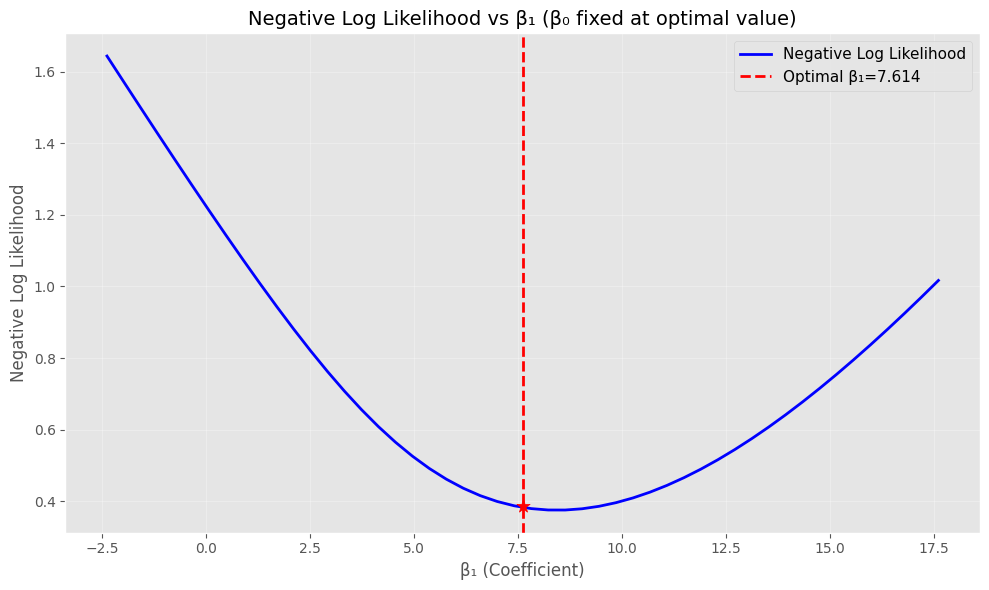

Optimal β₁: 7.613992
Minimum Negative Log Likelihood: 0.375266


In [254]:
from sklearn.metrics import log_loss

# Calculate negative log likelihood for different beta1 values

# Use the same beta1 range as before
beta1_values = np.linspace(optimal_beta1 - beta1_range, optimal_beta1 + beta1_range, n_points)

# Calculate negative log likelihood for each beta1 value (fixing beta0 at optimal)
neg_log_likelihood_beta1 = []

for beta1 in beta1_values:
    # Calculate predicted probabilities using manual logistic function
    linear_combination = optimal_beta0 + beta1 * np.array(X).flatten()
    y_prob_manual = 1 / (1 + np.exp(-linear_combination))
    
    # Calculate negative log likelihood
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    y_prob_clipped = np.clip(y_prob_manual, epsilon, 1 - epsilon)
    neg_log_likelihood = -np.mean(y * np.log(y_prob_clipped) + (1 - y) * np.log(1 - y_prob_clipped))
    neg_log_likelihood_beta1.append(neg_log_likelihood)

neg_log_likelihood_beta1 = np.array(neg_log_likelihood_beta1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(beta1_values, neg_log_likelihood_beta1, 'b-', linewidth=2, label='Negative Log Likelihood')
plt.axvline(optimal_beta1, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal β₁={optimal_beta1:.3f}')
plt.scatter(optimal_beta1, neg_log_likelihood_beta1[np.argmin(np.abs(beta1_values - optimal_beta1))], 
           color='red', s=100, marker='*', zorder=5)

plt.xlabel('β₁ (Coefficient)', fontsize=12)
plt.ylabel('Negative Log Likelihood', fontsize=12)
plt.title('Negative Log Likelihood vs β₁ (β₀ fixed at optimal value)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal β₁: {optimal_beta1:.6f}")
print(f"Minimum Negative Log Likelihood: {np.min(neg_log_likelihood_beta1):.6f}")

In [255]:
# Calculate mean square error for logistic regression predictions
y_prob_predictions = model.predict_proba(X)[:, 1]  # Get probabilities for class 1
mse = np.mean((y - y_prob_predictions) ** 2)

print(f"Mean Square Error (MSE): {mse:.6f}")

Mean Square Error (MSE): 0.113908


In [256]:
# Calculate log likelihood loss using scikit-learn
from sklearn.metrics import log_loss

# Calculate log loss on test set
test_log_loss = log_loss(y_test, y_pred)
print(f"Log Loss on Test Set: {test_log_loss:.4f}")

Log Loss on Test Set: 0.3574
